# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                      
Sample_172  Q9NPC4                                 14.683
Sample_121  A0A0A0MS09;P01880;P01880-2             15.515
Sample_067  B4DHN5;E9PBU7;G5EA09;O00560;O00560-2   13.155
Sample_076  P23470;P23470-2                        18.929
Sample_002  Q9NPG4                                 14.634
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups
Sample_135  O75976           12.932
Sample_120  Q9NSC7           12.400
Sample_044  Q2UY09           10.697
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.930
            A0A075B6Q5                 13.162
            A0A075B6R2                 12.224
            A0A075B6S5                 14.410
            A0A087WSY4                 13.723
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.019
            Q9UI40;Q9UI40-2            13.845
            Q9UIW2                     13.094
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.355
            Q9UP79                     13.499
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.158,15.050,16.842,19.863,13.559,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.872,19.067,...,15.528,15.576,12.404,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.108,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,11.962,17.705,17.039,14.275,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,11.658,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,11.989,15.345,17.084,18.708,14.249,19.433,10.842,8.366
Sample_207,15.739,16.877,15.469,16.898,9.948,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.930,...,16.012,15.178,13.030,15.050,16.842,19.863,13.546,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.878,19.067,16.188,...,15.528,15.576,12.400,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.654,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.420,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.719,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.476,15.345,17.084,18.708,14.249,19.433,12.888,12.005
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 145.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.26it/s]

100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.59it/s]

100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

100%|██████████| 3/3 [00:00<00:00,  3.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.22it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.03it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.40it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.92it/s]

100%|██████████| 5/5 [00:01<00:00,  2.74it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.45it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.40it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.87it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.71it/s]

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]

100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.16it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.69it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.50it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.44it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.37it/s]

100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.70it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.97it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.32it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.99it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.89it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.86it/s]

100%|██████████| 8/8 [00:03<00:00,  1.93it/s]

100%|██████████| 8/8 [00:03<00:00,  2.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.35it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.19it/s]

 44%|████▍     | 4/9 [00:01<00:02,  1.95it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.00it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.07it/s]

 78%|███████▊  | 7/9 [00:03<00:00,  2.09it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.10it/s]

100%|██████████| 9/9 [00:04<00:00,  2.10it/s]

100%|██████████| 9/9 [00:04<00:00,  2.13it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.10it/s]

 30%|███       | 3/10 [00:01<00:03,  2.33it/s]

 40%|████      | 4/10 [00:01<00:03,  1.99it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.84it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.91it/s]

 70%|███████   | 7/10 [00:03<00:01,  2.00it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.04it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.17it/s]

100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

100%|██████████| 10/10 [00:04<00:00,  2.16it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.78it/s]

 27%|██▋       | 3/11 [00:01<00:02,  2.69it/s]

 36%|███▋      | 4/11 [00:01<00:03,  2.20it/s]

 45%|████▌     | 5/11 [00:02<00:02,  2.13it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.02it/s]

 64%|██████▎   | 7/11 [00:03<00:01,  2.01it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.16it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.24it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.28it/s]

100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

100%|██████████| 11/11 [00:04<00:00,  2.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.47it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.88it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.16it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.90it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.85it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.87it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.03it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.18it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.34it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.34it/s]

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

100%|██████████| 12/12 [00:05<00:00,  2.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.31it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.60it/s]

 31%|███       | 4/13 [00:01<00:04,  2.02it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.89it/s]

 46%|████▌     | 6/13 [00:02<00:04,  1.75it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.86it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.12it/s]

 69%|██████▉   | 9/13 [00:04<00:01,  2.30it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.37it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.37it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.46it/s]

100%|██████████| 13/13 [00:05<00:00,  2.46it/s]

100%|██████████| 13/13 [00:05<00:00,  2.28it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.94it/s]

 21%|██▏       | 3/14 [00:00<00:03,  2.93it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.19it/s]

 36%|███▌      | 5/14 [00:02<00:04,  1.93it/s]

 43%|████▎     | 6/14 [00:02<00:04,  1.78it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.93it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.99it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  2.03it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.11it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  2.22it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.30it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.09it/s]

100%|██████████| 14/14 [00:06<00:00,  2.07it/s]

100%|██████████| 14/14 [00:06<00:00,  2.14it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.42it/s]

 20%|██        | 3/15 [00:01<00:04,  2.68it/s]

 27%|██▋       | 4/15 [00:01<00:05,  2.10it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.93it/s]

 40%|████      | 6/15 [00:02<00:04,  1.87it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.98it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.12it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.29it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.38it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.37it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.25it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.89it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.82it/s]

100%|██████████| 15/15 [00:07<00:00,  1.80it/s]

100%|██████████| 15/15 [00:07<00:00,  2.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.044 0.005          0.699 0.394       0.102   
2             0.004 0.002      0.048 0.008          0.763 0.093       0.688   
3             0.003 0.000      0.041 0.006          0.764 0.096       0.685   
4             0.006 0.005      0.074 0.025          0.762 0.099       0.699   
5             0.005 0.003      0.059 0.020          0.747 0.095       0.708   
6             0.004 0.003      0.056 0.018          0.768 0.092       0.741   
7             0.005 0.003      0.062 0.031          0.800 0.082       0.787   
8             0.004 0.001      0.051 0.017          0.811 0.086       0.791   
9             0.004 0.000      0.049 0.010          0.800 0.077       0.782   
10            0.005 0.003      0.052 0.014          0.799 0.084       0.786   
11            0.006 0.005      0.067 0.025          0.801 0.082       0.793   
12            0.007 0.006      0.075 0.030          0.795 0.084       0.789   
13            0.006 0.006      0.078 0.037          0.793 0.082       0.791   
14            0.006 0.005      0.072 0.033          0.791 0.080       0.781   
15            0.005 0.004      0.065 0.035          0.792 0.083       0.778   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.171 0.131                  0.544 0.041        0.844   
2          0.094   0.716 0.061                  0.761 0.047        0.846   
3          0.095   0.716 0.064                  0.761 0.050        0.840   
4          0.089   0.723 0.067                  0.766 0.055        0.844   
5          0.100   0.720 0.063                  0.762 0.050        0.850   
6          0.099   0.749 0.071                  0.786 0.059        0.887   
7          0.093   0.790 0.070                  0.820 0.058        0.903   
8          0.096   0.797 0.073                  0.826 0.061        0.903   
9          0.093   0.788 0.070                  0.819 0.059        0.905   
10         0.097   0.789 0.073                  0.820 0.063        0.905   
11         0.093   0.793 0.069                  0.823 0.059        0.902   
12         0.097   0.789 0.073                  0.819 0.064        0.900   
13         0.095   0.788 0.072                  0.819 0.063        0.899   
14         0.095   0.783 0.071                  0.814 0.062        0.898   
15         0.095   0.782 0.072                  0.813 0.062        0.897   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.819 0.089        210.000 0.000  
2          0.056                  0.826 0.065        210.000 0.000  
3          0.054                  0.819 0.064        210.000 0.000  
4          0.057                  0.826 0.063        210.000 0.000  
5          0.058                  0.833 0.065        210.000 0.000  
6          0.049                  0.874 0.052        210.000 0.000  
7          0.048                  0.892 0.050        210.000 0.000  
8          0.050                  0.893 0.052        210.000 0.000  
9          0.049                  0.898 0.047        210.000 0.000  
10         0.048                  0.899 0.046        210.000 0.000  
11         0.050                  0.896 0.048        210.000 0.000  
12         0.052                  0.893 0.050        210.000 0.000  
13         0.052                  0.892 0.050        210.000 0.000  
14         0.053                  0.892 0.051        210.000 0.000  
15         0.053                  0.890 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 460.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]

100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.86it/s]

100%|██████████| 4/4 [00:02<00:00,  1.62it/s]

100%|██████████| 4/4 [00:02<00:00,  1.77it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.67it/s]

 60%|██████    | 3/5 [00:01<00:01,  1.86it/s]

 80%|████████  | 4/5 [00:02<00:00,  1.51it/s]

100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.47it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.63it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.06it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

100%|██████████| 6/6 [00:03<00:00,  1.75it/s]

100%|██████████| 6/6 [00:03<00:00,  1.97it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.52it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.84it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.97it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.41it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.23it/s]

100%|██████████| 7/7 [00:02<00:00,  1.91it/s]

100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.79it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.73it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.33it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.57it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.86it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.62it/s]

100%|██████████| 8/8 [00:04<00:00,  1.45it/s]

100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  3.95it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.75it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.21it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.82it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.74it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.50it/s]

 89%|████████▉ | 8/9 [00:04<00:00,  1.43it/s]

100%|██████████| 9/9 [00:05<00:00,  1.44it/s]

100%|██████████| 9/9 [00:05<00:00,  1.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.68it/s]

 30%|███       | 3/10 [00:01<00:02,  2.81it/s]

 40%|████      | 4/10 [00:01<00:02,  2.67it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.10it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.65it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.62it/s]

100%|██████████| 10/10 [00:05<00:00,  1.55it/s]

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.68it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.26it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.87it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.55it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.35it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.88it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  1.68it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.61it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.54it/s]

100%|██████████| 11/11 [00:05<00:00,  1.61it/s]

100%|██████████| 11/11 [00:05<00:00,  1.93it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.25it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.32it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.89it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.77it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.64it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.27it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.89it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  1.71it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.55it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.56it/s]

100%|██████████| 12/12 [00:05<00:00,  1.66it/s]

100%|██████████| 12/12 [00:05<00:00,  2.00it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.97it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.43it/s]

 31%|███       | 4/13 [00:01<00:03,  2.93it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.86it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.78it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.03it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.70it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.57it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.55it/s]

 85%|████████▍ | 11/13 [00:05<00:01,  1.69it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.75it/s]

100%|██████████| 13/13 [00:06<00:00,  1.84it/s]

100%|██████████| 13/13 [00:06<00:00,  2.02it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.73it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.70it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.22it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.09it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.01it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.48it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.00it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  1.70it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.62it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.61it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.71it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.85it/s]

100%|██████████| 14/14 [00:06<00:00,  1.75it/s]

100%|██████████| 14/14 [00:06<00:00,  2.07it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.39it/s]

 20%|██        | 3/15 [00:00<00:03,  3.35it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.02it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.01it/s]

 40%|████      | 6/15 [00:02<00:03,  2.65it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.05it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.78it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.67it/s]

 67%|██████▋   | 10/15 [00:04<00:03,  1.55it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.62it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.78it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.61it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.65it/s]

100%|██████████| 15/15 [00:07<00:00,  1.64it/s]

100%|██████████| 15/15 [00:07<00:00,  1.91it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.082 0.033          0.813 0.297       0.139   
2             0.006 0.006      0.080 0.039          0.763 0.096       0.632   
3             0.007 0.005      0.077 0.031          0.734 0.093       0.620   
4             0.004 0.003      0.063 0.029          0.769 0.082       0.790   
5             0.005 0.004      0.065 0.027          0.769 0.078       0.787   
6             0.006 0.008      0.066 0.028          0.792 0.093       0.780   
7             0.007 0.006      0.093 0.039          0.788 0.090       0.792   
8             0.007 0.007      0.083 0.044          0.797 0.089       0.802   
9             0.005 0.003      0.067 0.027          0.788 0.089       0.794   
10            0.005 0.004      0.075 0.032          0.812 0.084       0.827   
11            0.005 0.004      0.071 0.030          0.820 0.082       0.829   
12            0.009 0.009      0.089 0.041          0.834 0.087       0.825   
13            0.007 0.006      0.081 0.040          0.840 0.087       0.822   
14            0.007 0.006      0.093 0.042          0.842 0.084       0.823   
15            0.006 0.005      0.082 0.041          0.832 0.086       0.819   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.230 0.130                  0.562 0.044        0.851   
2          0.114   0.685 0.091                  0.743 0.065        0.803   
3          0.120   0.665 0.088                  0.726 0.062        0.799   
4          0.110   0.774 0.075                  0.807 0.063        0.884   
5          0.114   0.773 0.077                  0.806 0.065        0.883   
6          0.104   0.780 0.072                  0.812 0.060        0.890   
7          0.105   0.785 0.073                  0.816 0.062        0.891   
8          0.098   0.795 0.067                  0.824 0.058        0.892   
9          0.103   0.785 0.070                  0.816 0.060        0.889   
10         0.103   0.815 0.072                  0.842 0.063        0.905   
11         0.100   0.820 0.066                  0.846 0.057        0.906   
12         0.096   0.826 0.071                  0.851 0.060        0.919   
13         0.099   0.827 0.074                  0.853 0.063        0.917   
14         0.101   0.829 0.076                  0.854 0.064        0.915   
15         0.103   0.821 0.073                  0.847 0.061        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.824 0.088        210.000 0.000  
2          0.074                  0.774 0.094        210.000 0.000  
3          0.071                  0.768 0.090        210.000 0.000  
4          0.048                  0.866 0.062        210.000 0.000  
5          0.046                  0.863 0.059        210.000 0.000  
6          0.048                  0.860 0.062        210.000 0.000  
7          0.050                  0.863 0.066        210.000 0.000  
8          0.050                  0.865 0.062        210.000 0.000  
9          0.052                  0.861 0.064        210.000 0.000  
10         0.051                  0.892 0.055        210.000 0.000  
11         0.053                  0.895 0.057        210.000 0.000  
12         0.047                  0.909 0.049        210.000 0.000  
13         0.049                  0.908 0.051        210.000 0.000  
14         0.050                  0.903 0.058        210.000 0.000  
15         0.049                  0.910 0.056 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 953.03it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.53it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.19it/s]

100%|██████████| 3/3 [00:00<00:00, 16.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 16.14it/s]

100%|██████████| 4/4 [00:00<00:00, 13.91it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.21it/s]

100%|██████████| 5/5 [00:00<00:00, 10.17it/s]

100%|██████████| 5/5 [00:00<00:00, 10.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.07it/s]

100%|██████████| 6/6 [00:00<00:00, 11.70it/s]

100%|██████████| 6/6 [00:00<00:00, 12.41it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 16.33it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 11.33it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 10.71it/s]

100%|██████████| 7/7 [00:00<00:00, 11.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.50it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.12it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 11.47it/s]

100%|██████████| 8/8 [00:00<00:00, 12.08it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.16it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 12.54it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 11.84it/s]

100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

100%|██████████| 9/9 [00:00<00:00, 12.61it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.96it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.57it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.46it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.35it/s]

100%|██████████| 10/10 [00:00<00:00, 11.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.13it/s]

 36%|███▋      | 4/11 [00:00<00:00, 15.22it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.63it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.49it/s]

 91%|█████████ | 10/11 [00:00<00:00,  9.32it/s]

100%|██████████| 11/11 [00:01<00:00, 10.44it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 13.83it/s]

 33%|███▎      | 4/12 [00:00<00:00,  9.43it/s]

 50%|█████     | 6/12 [00:00<00:00,  8.19it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.04it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.98it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  9.86it/s]

100%|██████████| 12/12 [00:01<00:00,  9.49it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 15.91it/s]

 31%|███       | 4/13 [00:00<00:00, 11.05it/s]

 46%|████▌     | 6/13 [00:00<00:00, 10.81it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 11.61it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 11.84it/s]

 92%|█████████▏| 12/13 [00:01<00:00, 12.17it/s]

100%|██████████| 13/13 [00:01<00:00, 11.80it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.71it/s]

 43%|████▎     | 6/14 [00:00<00:00, 11.47it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.88it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 12.10it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 11.64it/s]

100%|██████████| 14/14 [00:01<00:00, 11.53it/s]

100%|██████████| 14/14 [00:01<00:00, 11.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 21.35it/s]

 40%|████      | 6/15 [00:00<00:00, 13.62it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.38it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.90it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.59it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.12it/s]

100%|██████████| 15/15 [00:01<00:00, 11.51it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.048 0.009          0.337 0.451       0.026   
2             0.006 0.005      0.071 0.027          0.605 0.178       0.286   
3             0.004 0.003      0.055 0.019          0.603 0.160       0.309   
4             0.004 0.000      0.050 0.010          0.600 0.125       0.301   
5             0.006 0.005      0.066 0.027          0.602 0.135       0.359   
6             0.004 0.001      0.055 0.018          0.599 0.137       0.397   
7             0.004 0.000      0.049 0.011          0.594 0.136       0.376   
8             0.004 0.002      0.049 0.010          0.576 0.116       0.376   
9             0.004 0.000      0.049 0.009          0.562 0.126       0.371   
10            0.004 0.002      0.049 0.010          0.550 0.120       0.369   
11            0.004 0.001      0.047 0.003          0.552 0.122       0.377   
12            0.004 0.001      0.050 0.014          0.529 0.133       0.414   
13            0.004 0.001      0.048 0.006          0.539 0.121       0.442   
14            0.005 0.002      0.051 0.012          0.623 0.122       0.581   
15            0.004 0.001      0.050 0.011          0.643 0.107       0.584   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.037   0.048 0.067                  0.510 0.018        0.710   
2          0.108   0.378 0.118                  0.573 0.058        0.649   
3          0.109   0.399 0.117                  0.581 0.054        0.647   
4          0.103   0.388 0.104                  0.573 0.047        0.632   
5          0.116   0.436 0.106                  0.587 0.059        0.632   
6          0.115   0.470 0.114                  0.600 0.074        0.633   
7          0.112   0.452 0.107                  0.592 0.066        0.624   
8          0.111   0.446 0.101                  0.584 0.064        0.618   
9          0.115   0.438 0.108                  0.577 0.068        0.606   
10         0.111   0.434 0.105                  0.573 0.064        0.599   
11         0.118   0.440 0.111                  0.577 0.068        0.598   
12         0.118   0.458 0.109                  0.570 0.079        0.621   
13         0.112   0.480 0.103                  0.581 0.079        0.615   
14         0.139   0.594 0.114                  0.660 0.090        0.737   
15         0.127   0.606 0.103                  0.673 0.079        0.756   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.668 0.079        210.000 0.000  
2          0.083                  0.600 0.091        210.000 0.000  
3          0.092                  0.592 0.102        210.000 0.000  
4          0.091                  0.579 0.096        210.000 0.000  
5          0.084                  0.586 0.093        210.000 0.000  
6          0.082                  0.588 0.098        210.000 0.000  
7          0.079                  0.579 0.092        210.000 0.000  
8          0.077                  0.565 0.089        210.000 0.000  
9          0.082                  0.554 0.090        210.000 0.000  
10         0.078                  0.546 0.086        210.000 0.000  
11         0.079                  0.546 0.087        210.000 0.000  
12         0.083                  0.551 0.088        210.000 0.000  
13         0.083                  0.549 0.090        210.000 0.000  
14         0.088                  0.680 0.109        210.000 0.000  
15         0.079                  0.713 0.095 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,12,12,2
score_time,13,7,2
test_precision,8,14,15
test_recall,11,11,15
test_f1,8,14,15
test_balanced_accuracy,8,14,15
test_roc_auc,10,15,15
test_average_precision,10,15,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.41it/s]

 20%|██        | 3/15 [00:00<00:03,  3.17it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.90it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.83it/s]

 40%|████      | 6/15 [00:02<00:03,  2.79it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.72it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.77it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.71it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.81it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.70it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.20it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.93it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  1.70it/s]

100%|██████████| 15/15 [00:06<00:00,  1.56it/s]

100%|██████████| 15/15 [00:06<00:00,  2.24it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.86it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.27it/s]

 40%|████      | 6/15 [00:00<00:00, 10.41it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.06it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.53it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.59it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.02it/s]

100%|██████████| 15/15 [00:01<00:00, 10.80it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.25it/s]

 30%|███       | 3/10 [00:00<00:01,  3.79it/s]

 40%|████      | 4/10 [00:01<00:02,  2.98it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.60it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.39it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.41it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.43it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.44it/s]

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  2.70it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


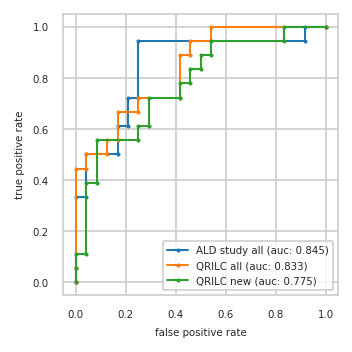

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.000 0.056
2          0.000 0.333     0.000 0.444     0.000 0.111
3          0.042 0.333     0.042 0.444     0.042 0.111
4          0.042 0.500     0.042 0.500     0.042 0.389
5          0.167 0.500     0.125 0.500     0.083 0.389
6          0.167 0.611     0.125 0.556     0.083 0.556
7          0.208 0.611     0.167 0.556     0.250 0.556
8          0.208 0.722     0.167 0.667     0.250 0.611
9          0.250 0.722     0.250 0.667     0.292 0.611
10         0.250 0.944     0.250 0.722     0.292 0.722
11         0.917 0.944     0.417 0.722     0.417 0.722
12         0.917 1.000     0.417 0.889     0.417 0.778
13         1.000 1.000     0.458 0.889     0.458 0.778
14           NaN   NaN     0.458 0.944     0.458 0.833
15           NaN   NaN     0.542 0.944     0.500 0.833
16           NaN   NaN     0.542 1.000     0.500 0.889
17           NaN   NaN     1.000 1.000     0.542 0.889
18           NaN   NaN       NaN   NaN     0.542 0.944
19           NaN   NaN       NaN   NaN     0.833 0.944
20           NaN   NaN       NaN   NaN     0.833 1.000
21           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P31321
1,P00740;P00740-2,P60709;P63261,A0A0B4J1V6
2,Q15782;Q15782-6,A6H8L4;E7EUI5;P78536;P78536-2,Q14894
3,Q9NR34,P10636-2;P10636-6,D6R956;P09936
4,P04075,A0A0A0MRJ7;P12259,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
5,P61981,P61981,H0Y7T8;P49418;P49418-2
6,C9JF17;P05090,P14174,P10644;P10644-2
7,P14174,P04075,A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;...
8,Q9Y2T3;Q9Y2T3-3,P00338;P00338-3,P30048;P30048-2


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


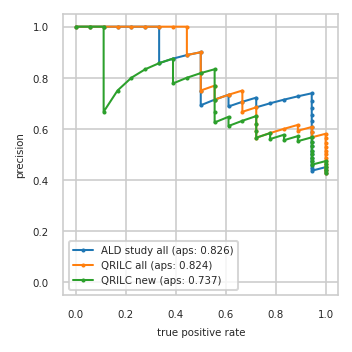

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.459 0.944
6          0.472 0.944     0.500 1.000     0.472 0.944
7          0.486 0.944     0.514 1.000     0.486 0.944
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.567 0.944     0.567 0.944
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.571 0.889
15         0.630 0.944     0.593 0.889     0.556 0.833
16         0.654 0.944     0.615 0.889     0.577 0.833
17         0.680 0.944     0.600 0.833     0.560 0.778
18         0.708 0.944     0.583 0.778     0.583 0.778
19         0.739 0.944     0.565 0.722     0.565 0.722
20         0.727 0.889     0.591 0.722     0.591 0.722
21         0.714 0.833     0.619 0.722     0.619 0.722
22         0.700 0.778     0.650 0.722     0.650 0.722
23         0.684 0.722     0.684 0.722     0.632 0.667
24         0.722 0.722     0.667 0.667     0.611 0.611
25         0.706 0.667     0.706 0.667     0.647 0.611
26         0.688 0.611     0.750 0.667     0.625 0.556
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.714 0.556     0.714 0.556     0.714 0.556
29         0.692 0.500     0.769 0.556     0.769 0.556
30         0.750 0.500     0.750 0.500     0.833 0.556
31         0.818 0.500     0.818 0.500     0.818 0.500
32         0.900 0.500     0.900 0.500     0.800 0.444
33         0.889 0.444     0.889 0.444     0.778 0.389
34         0.875 0.389     1.000 0.444     0.875 0.389
35         0.857 0.333     1.000 0.389     0.857 0.333
36         1.000 0.333     1.000 0.333     0.833 0.278
37         1.000 0.278     1.000 0.278     0.800 0.222
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


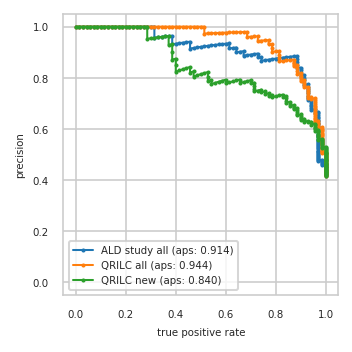

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


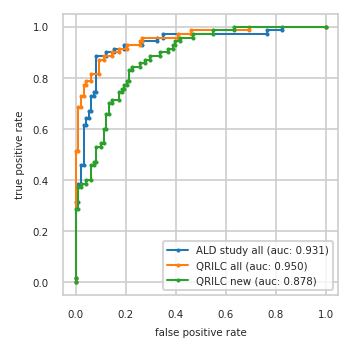

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}